# General analysis of a simulation

In [1]:
using HDF5
using PyPlot

In [2]:
thermostat = "Gaussian"
filename = "fcc256.hdf5" #The file must exist in the HDF5 folder
file = h5open("../data/$(thermostat)/HDF5/$filename", "r");

In [3]:
sim = read(file);

In [7]:
t = sim["t"]
E = sim["E"]
K = sim["K"]
U = sim["U"];
T = sim["T"]
i = sim["invariant"]
zeta = sim["zeta"]
nu = sim["nu"]
qatom = sim["qatom"]
patom = sim["patom"];

In [8]:
N = read(attrs(file)["N"])  
dt = read(attrs(file)["deltat"])  
Q = read(attrs(file)["Q"])   ##Parameter associated to the thermostat

1.0

## Equilibrium

The approach to follows is to plot the temperature and establish the time when the equilibrium is reached, in order to discard the initial data

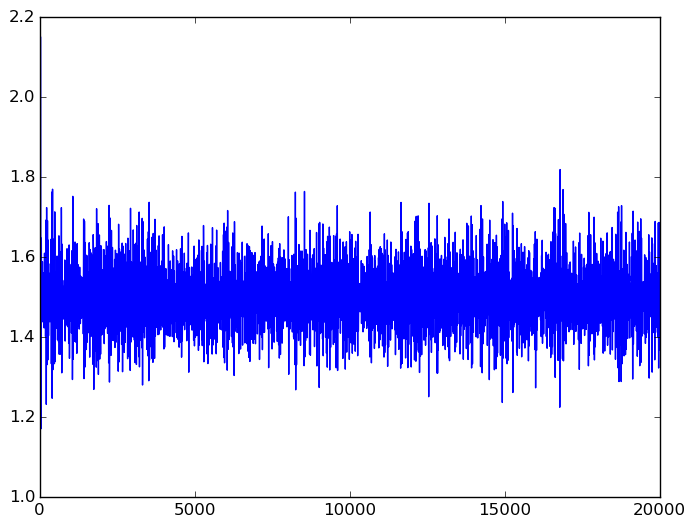

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f73ee015350>

In [9]:
plot(T)

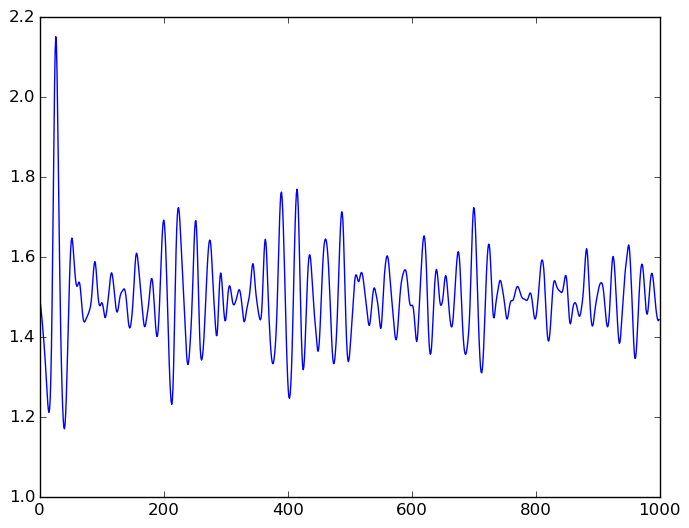

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f73edf76fd0>

In [10]:
plot(T[1:1000])

In [11]:
stepeq = 1000;  ##Step where the equilibrium seems to be a fact

1000

## Units

For going from reduced units (with `*`) to physical units one uses the following rules (taken from **Frenkel's book**)

+ $U = U^* \epsilon$ 
+ $\rho = \dfrac{\rho^* m}{\sigma^3}$ (in $kg/m^3$)
+ $\rho = \dfrac{\rho^* m}{\sigma^3 1000 \rm{AW}}$ (in $mol/L$)
+ $T = T^* \dfrac{\epsilon}{k_B}$
+ $C_v = C_v^*\dfrac{k_B AW}{m}$
+ $\Delta t = \Delta t^* \sigma \sqrt{\dfrac{m}{\epsilon}}$

Where AW stands for atomic weight.

In particular for Ar, the following data are used

| Quantity | Typical value |
| ---------|:-------------- |
| $\dfrac{\epsilon}{k_B}$ | $119.8  K$ |
| $\sigma$ | $3.405 x 10^{-10}  m$ |
| $m$ | $6.69 x 10^{-26}$  kg |
| $AW$ | $0.03994$ kg/mol |

With that, we convert the data used in the simulation as follows:


In [12]:
σ = 3.405e-10 
m = 6.69e-26
kb = 1.38064852e-23
ratio = 119.8
ϵ = kb*ratio
AW = 0.039948
Text = read(attrs(file)["T"])  
ρ = read(attrs(file)["rho"]); 
rhophysical = ρ*m/(σ^3*1000*AW)
Tphysical = Text*ratio
deltat = dt*σ*sqrt(m/ϵ)
println("Treduced = $(Text), Tphysical = $(Tphysical) K, rhophysical = $(rhophysical) mol/L, tphysical = $(deltat) s")

Treduced = 1.5, Tphysical = 179.7 K, rhophysical = 33.936708244735506 mol/L, tphysical = 1.0827550166634764e-14 s


We then look for the physical properties at the [NIST webpage](http://webbook.nist.gov/chemistry/fluid/). In particular, for the heat capacity $C_v$. In this case its value is $18.669$ J/molK. We proceed to convert it to reduced units.


In [13]:
Cv_reduced = 18.669*m/(kb*AW)
println("Cv_reduced = $Cv_reduced")

Cv_reduced = 2.264482665749965


This is the value that we will compare with the fluctuations in energy 

## Fluctuations

General formula for fluctuations in energy in the canonical ensemble 

$$ C_vNk_B T^2 = \langle (H - \langle H \rangle)^2 \rangle  $$

In our case, we use the mean value of T  (from [Valenzuela's paper](http://www.tandfonline.com/doi/abs/10.1080/08927022.2014.895077?journalCode=gmos20#.Vw08mCYtg8o))

$$ C_v = \dfrac{\langle (H - \langle H \rangle)^2 \rangle}{N k_B \langle T \rangle ^2} $$

And the reduced heat capacity is

$$ C_v^* = \dfrac{\langle (H - \langle H \rangle)^2 \rangle}{N \langle T^* \rangle ^2} $$

In [14]:
e = E[stepeq:end]; temp = T[stepeq:end];

In [15]:
flucte = mean((e - mean(e)).^2)

1280.3916593520003

In [16]:
Cv = flucte/(N*mean(temp)^2)

2.2229884496218766

## Covariance 

The covariance between the Kinetic and potential energy is defined by the formula

$$
cov^*(K,U) = \frac{\langle (K - \bar{K})(U - \bar{U})}{N \langle T^* \rangle}^2
$$

In [17]:
k = K[stepeq:end]; u = U[stepeq:end];

In [18]:
mean((k - mean(k)).* (u - mean(u)))/(N*mean(temp)^2)

0.0030435650830322888

## Invariant

The invariant is analyzed after equilibrium is reached. In particular the scaled invariant is analyzed

In [19]:
inv = i[stepeq:end];

In [20]:
invred = (inv - inv[1])./inv[1];
time = t[stepeq:end];

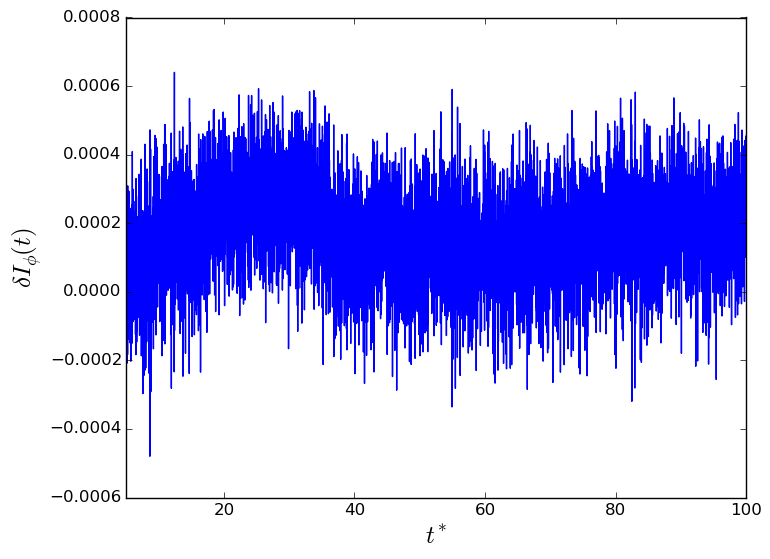

(5.0,100.0)

In [21]:
plot(time,invred)
plt[:xlabel](L"t^*", fontsize =18)
plt[:ylabel](L"\delta I_{\phi}(t)", fontsize = 18)
plt[:xlim](5.,100.)

## Energy Distribution

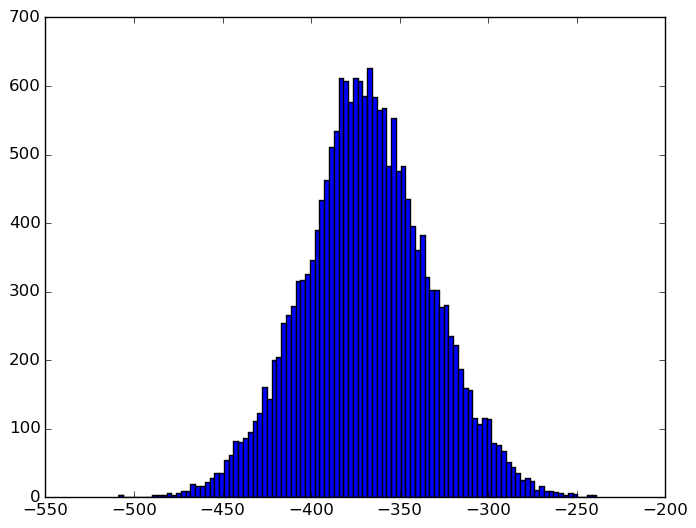

In [25]:
plt[:hist](e,100);

In [26]:
##Theoretical distribution saved in a file

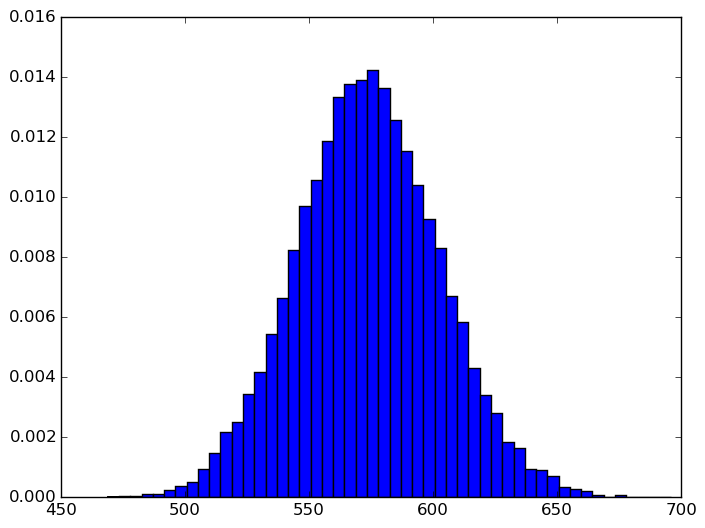

In [28]:
plt[:hist](k,50, normed = 1)
plt[:xlim](450,700);

In [29]:
timered = t[stepeq:end];
meank = mean(k)*ones(timered);

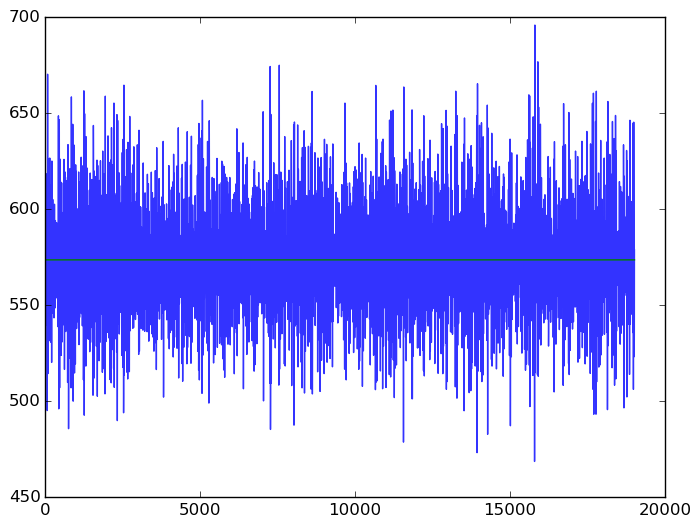

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f73ed6f8990>

In [30]:
plot(k,alpha=0.8)
plot(meank,"g")

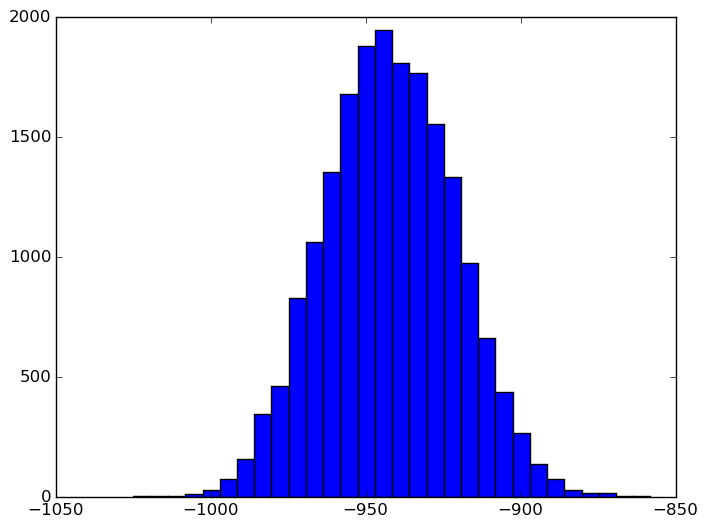

In [32]:
plt[:hist](u,30);


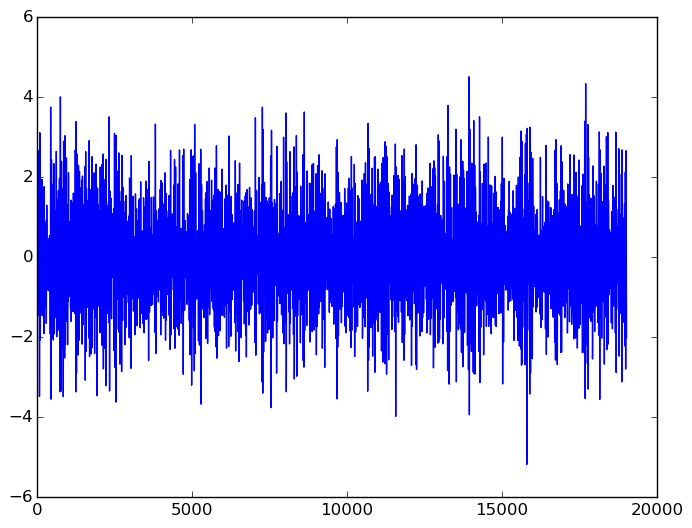

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f73ed4dded0>

In [33]:
plot(zeta[stepeq:end])

## Plotting 

In [34]:
using PyCall
@pyimport matplotlib as mpl
mpl.style[:use]("ggplot")


In [37]:
if thermostat == "Logistic"
    color = "m"
    elseif thermostat == "Gaussian"
    color = "b"
    elseif thermostat == "Quartic"
    color = "g"
end;

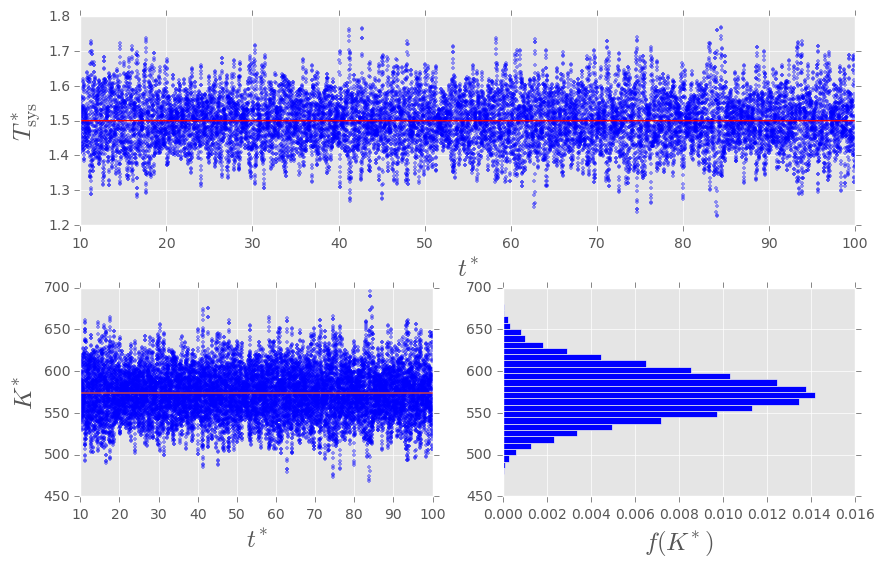

In [40]:
fig = plt[:figure](figsize=(10,6))
fig[:subplots_adjust](hspace=.3)

meanT = mean(T[stepeq:end])

ax1 = plt[:subplot2grid]((2,2), (0,0), colspan=2)
ax2 =  plt[:subplot2grid]((2,2), (1,0))
ax3 =  plt[:subplot2grid]((2,2), (1,1))

ax1[:plot](timered,T[stepeq:end],"$color.", alpha =0.4, markeredgewidth=0.)
ax1[:plot](timered,meanT*ones(timered),"r")
ax1[:set_xlim](10.,100)
ax1[:set_ylim](1.2,1.8)
ax1[:set_ylabel](L"$T_{\rm sys}^*$",fontsize="18")
ax1[:set_xlabel](L"$t^*$",fontsize="18")

ax2[:plot](timered, k,"$color.", alpha =0.4, markeredgewidth=0.)
ax2[:plot](timered, meank)
ax2[:set_xlim](10.,100)
ax2[:set_ylabel](L"$K^*$",fontsize="18")
ax2[:set_xlabel](L"$t^*$",fontsize="18")

ax3[:hist](k, 30, normed =1, color = "$color",orientation = "horizontal")
ax3[:set_ylim](450,700)
ax3[:set_xlabel](L"$f(K^*)$",fontsize="18")

plt[:savefig]("$(thermostat)15.png")
plt[:show]()